In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad

In [18]:

class DNN(nn.Module):
    def __init__(self, input_dim, hidden_shapes, output_dim):
        self.model = nn.Sequential(
            nn.Linear(input_dim, 100),
            nn.ReLU(),
            nn.Linear(100,100),
            nn.ReLU(),
            nn.Linear(100,output_dim)
        )
    
    def forward(self, x):
        return self.model(x)


class LossFunction:
    def __init__(self, differential_expressions, bc_orders, bc_functions, boundaries, boundary_conditions):
        # Differential expression term F(x,f(x),f'(x),...)
        self.differential_expressions = differential_expressions
        # Boundary condition term sum_i (grad^{p_i} f(x_{b_i})- K_i(x_{b_i}))^2
        self.bc_orders = bc_orders  # integer p
        self.bc_functions = bc_functions  # function K(x_b)
        self.boundaries = boundaries  # values x_b
    
    def _calcBC(self, model):
        # Just calculates result for all boundaries

        # bc_orders is list if integer values
        # bc_functions is list of functions
        # boundaries is list of values

        # NB does not currently calculate any derivatives
        return (model(self.boundaries) - self.bc_functions(self.boundaries)).square().sum()
        
    
    def __call__(self, model, x_data):
        # (sum_i F(x_i,f(x_i),f'(x_i),...))^2
        # QUESTION do you calculate boundary condition everytime even with smaller batches?
        # QUESTION shuold you remove the boundary values from x_data?
        x_max = x_data.shape[0]
        return self.differential_expressions(model, x_data).square().sum() / x_max + self._calcBC(model)




def training(model, loss_fn, dataloader, num_epochs, learning_rate):
    # Possible parameters for Adam: ...
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    loss_history = []
    for epoch_i in range(num_epochs):
        # model.train()  # NB train is default. Can also set model.eval()
        running_loss = 0.0
        for batch_i, data in enumerate(dataloader):
            x, _ = data

            optimizer.zero_grad()

            # Forward pass (not actually needed here?)
            # y = model(x)

            # Backward pass
            loss = loss_fn(model, x)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        loss_history.append(running_loss)
        print("Epoch {}/{} Loss: {:.4f}". format(epoch_i+1, num_epochs, running_loss))

    return loss_history




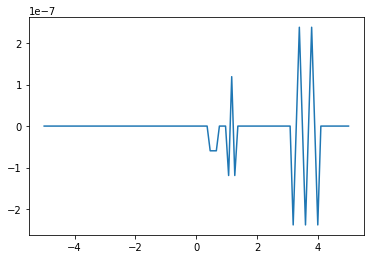

In [16]:
# Example f'(x) - x - 1 = 0
# Solution f(x) = x^2/2 + x + c, c is determined by boundary conditions
def equation1(f, x):
    assert isinstance(x, torch.Tensor), "x must be a Pytorch tensor"
    assert x.requires_grad, "x must have `requires_grad=True`"
    y = f(x)
    f_prime = grad(outputs=y, inputs=x, grad_outputs=torch.ones_like(x))[0]
    return f_prime - x - 1


def f_test(x):
    return x**2 * 0.5 + x


def model_dummy(x):
    return x**2


x_test = torch.linspace(-5, 5, 100, requires_grad=True)
# x_test = torch.tensor(0.4, requires_grad=True)

y_test = equation1(f_test, x_test)


plt.plot(x_test.detach(), y_test.detach())
plt.show()

In [19]:
mylossfn = LossFunction(equation1, None)
mylossfn(model_dummy, x_test)

tensor([-6.0000, -5.8990, -5.7980, -5.6970, -5.5960, -5.4949, -5.3939, -5.2929,
        -5.1919, -5.0909, -4.9899, -4.8889, -4.7879, -4.6869, -4.5859, -4.4848,
        -4.3838, -4.2828, -4.1818, -4.0808, -3.9798, -3.8788, -3.7778, -3.6768,
        -3.5758, -3.4747, -3.3737, -3.2727, -3.1717, -3.0707, -2.9697, -2.8687,
        -2.7677, -2.6667, -2.5657, -2.4646, -2.3636, -2.2626, -2.1616, -2.0606,
        -1.9596, -1.8586, -1.7576, -1.6566, -1.5556, -1.4545, -1.3535, -1.2525,
        -1.1515, -1.0505, -0.9495, -0.8485, -0.7475, -0.6465, -0.5455, -0.4444,
        -0.3434, -0.2424, -0.1414, -0.0404,  0.0606,  0.1616,  0.2626,  0.3636,
         0.4646,  0.5657,  0.6667,  0.7677,  0.8687,  0.9697,  1.0707,  1.1717,
         1.2727,  1.3737,  1.4747,  1.5758,  1.6768,  1.7778,  1.8788,  1.9798,
         2.0808,  2.1818,  2.2828,  2.3838,  2.4848,  2.5859,  2.6869,  2.7879,
         2.8889,  2.9899,  3.0909,  3.1919,  3.2929,  3.3939,  3.4949,  3.5960,
         3.6970,  3.7980,  3.8990,  4.00